In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

# random seed for reproducibility
npr.seed(12345)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from IPython.display import display_html

In [2]:
# select analysis to perform
CASE = 2
if CASE == 0:
    data_name = 'DATA'
    # size of each block of data (!= 1 for one-hot)
    BLSIZE = 1
    # number of hidden units
    M = 3
elif CASE == 1:
    dname = 'DATA_b'
    BLSIZE = 4
    M = 2
elif CASE == 2:
    dname = 'DATA_c'
    BLSIZE = 6
    M = 2
fname = dname + '/x_RBM_q0.1.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible
v = np.loadtxt(fname, delimiter=' ', dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)

# N = size of input
N = len(v)
# L = size of each sample
L = len(v[1])

# if SPINS = True, values in {-1, +1}, otherwise {0, 1}
SPINS = False

if SPINS:
    # sigmoid takes into account energy diff = 2
    GAP = 2
    # convert 0, 1 -> -1, 1
    v = 2 * v - 1
    VMIN = -1 
else:
    GAP = 1
    VMIN = 0

# range of each initial weight
sigma = np.sqrt(4 / float(L + M))
# initial weights from a normal distribution
w = sigma * npr.randn(L, M)
a = sigma * np.random.randn(L)
b = np.zeros(M)

w0, a0, b0 = np.copy(w), np.copy(a), np.copy(b)

In [3]:
(x_vis, y_vis) = (np.zeros(L), np.linspace(-0.5, 0.5, L))
(x_hid, y_hid) = (np.ones(M), np.linspace(-0.35, 0.35, M))

def mycolor(value):
    if value > 0: return 'red'
    elif value < 0: return 'blue'
    return 'black'

# plot network with weights and units, all color-coded
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # remove ticks
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

    # scale for line width based on max weight
    lw_scale = 1 / abs(w).max()
    for i in range(L):
        for j in range(M):
            ex = (y_vis[i], y_hid[j])
            ey = (x_vis[i], x_hid[j])
            col = mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=lw_scale * abs(w[i][j]))

    # scale for circles representing the units
    circ_scale = 500
    
    # plot visible units
    for i in range(L):
        ax.scatter(y_vis[i], x_vis[i], s=circ_scale * abs(a[i]),
                   zorder=2, c=mycolor(a[i]))

    # plot hidden units (with square markers)
    for j in range(M):
        ax.scatter(y_hid[j], x_hid[j], s=min(300, circ_scale * abs(b[j])),
                   zorder=2, c=mycolor(b[j]), marker='s')
    
    ax.set_title(f'Red > 0, Blue < 0, Epoch = {epoch}')
    ax.text(-0.5, 0.9, 'Hidden\nlayer')
    plt.show()

In [4]:
# put phase = 1 if in positive CD phase, if in negative --> phase != 1
def activate(in_layer, weights, bias, phase, info=False):
    act = bias + np.dot(in_layer, weights)

    # prepare a list of -1s or 0s (depending on SPINS = T/F)
    out_layer = np.full(act.shape, VMIN, dtype=int)

    if phase == 1:
        # here we don’t want one-hot blocks in the output
        p = npr.random_sample((len(act), ))
        # like below but simpler (no cdf, only two levels)
        prob = 1 / (1 + np.exp(-GAP * act))
        out_layer[p < prob] = 1
    else:
        # how many random samples do we need? len(in_layer) // block
        num_gen = len(act) // BLSIZE
        p = npr.random_sample((num_gen, ))
        for i in range(num_gen):
            # cumulated boltzmann weights
            block = act[(i * BLSIZE):((i + 1) * BLSIZE)]
            prob = np.cumsum(np.exp(GAP * block))
            # normalization (so the tail of cdf is 1)
            prob /= prob[-1]
            # put out_layer = 1 in the previous index to the one where
            # the generated number is higher than the cdf 
            out_layer[np.argmax(p[i] < prob) + i * BLSIZE] = 1

    if info: # print debug
       print(f'in_layer = {in_layer}') 
       print(f'act = {act}')
       print(f'prob = {prob}')
       print(f'out_layer = {out_layer}')

    return out_layer

In [5]:
def rmsprop(data, model, s, beta, eps, lrate):
    g = data - model # gradient
    s1 = beta * s + (1 - beta) * g**2
    d = lrate * g / np.sqrt(s1 + eps)

    return s1, d

def adam(data, model, m, s, t, beta, eps, lrate):
    g = data - model # gradient
    m0 = beta * m + (1 - beta) * g
    s0 = beta * s + (1 - beta) * g**2

    m1 = m0 / (1 - beta**(t + 1))
    s1 = s0 / (1 - beta**(t + 1))
    d = lrate * m1 / np.sqrt(s1 + eps)

    return m0, s0, d

In [6]:
import itertools

def Energy(v, h, w, a, b):
    return -a.dot(v)-h.dot(b)-((v.T).dot(w)).dot(h)

def PartZ(w, a, b):
    res = 0
    aaa=True
    if aaa==True:
        blocks = np.fliplr( np.eye(BLSIZE) )
        if(SPINS==True):
            blocks[blocks==0]=-1
        n = L//BLSIZE
        
        # Create the ohes
        element = [b for b in blocks]
        # Create a list with all possible combinations of the ohes
        combinations = list(itertools.product( element, repeat=n))
        # Create a matrix with all possible combinations of the ohes
        OHM = []
        for c in combinations:
            row = []
            for e in c:
                row += [e]
            OHM.append(np.hstack(row))
            
        for i in range(2**M):
            h=np.array([(i//2**j)%2 for j in reversed(range(M))])
            for v in OHM:
                res += np.exp(-Energy(v, h, w, a, b))
               
              
        
    '''if SPINS==False:
        for i in range(2**M):
            h=np.array([(i//2**j)%2 for j in reversed(range(M))])
            res = np.exp(b.dot(h))
            expact = np.exp(a+w.dot(h))
            for j in range(L//BLSIZE):
                res*=sum(expact[j*BLSIZE:(j+1)*BLSIZE])'''
    return res

In [7]:
def dist(d1, d2):
    return np.abs(d1-d2).sum(axis=1)


#d1=np.array([[1,0,0,0]])
#d2=np.array([[0,1,0,0]])
#dist(d1, d2)

def AAI(v0,v1,batch_len=10):
    bl=batch_len
    cg=0 ## count for generated data
    co=0 ## count for original data
    for n in range(len(v1)//bl):
        b1=v1[n*bl:(n+1)*bl,]
        b0=v0[n*bl:(n+1)*bl,]
        for i in range(len(b1)):
            b2=np.array([b1[i]]*len(b1))
            mask=np.array([k!=i for k in range(len(b1))])
            #print(b2, mask)
            d_st=min(dist(b2[mask],b0[mask]))
            d_ss=min(dist(b2[mask],b1[mask]))
            if d_ss<d_st:
                cg+=1
            elif d_ss==d_st:
                cg+=0.5
        
        for i in range(len(b0)):
            b2=np.array([b0[i]]*len(b0))
            mask=np.array([k!=i for k in range(len(b0))])
            d_tt=min(dist(b2[mask],b0[mask]))
            d_st=min(dist(b2[mask],b1[mask]))
            if d_tt<d_st:
                co+=1
            elif d_tt==d_st:
                co+=0.5
    
    co/=len(v0)
    cg/=len(v1)
    return cg, co, (co-0.5)**2+(cg-0.5)**2

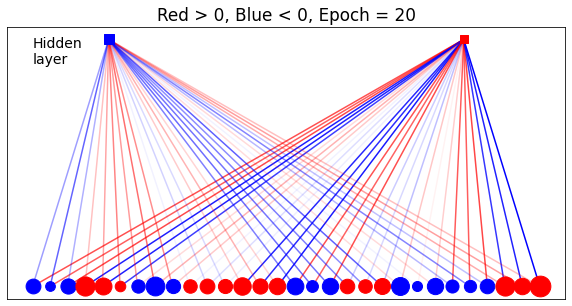

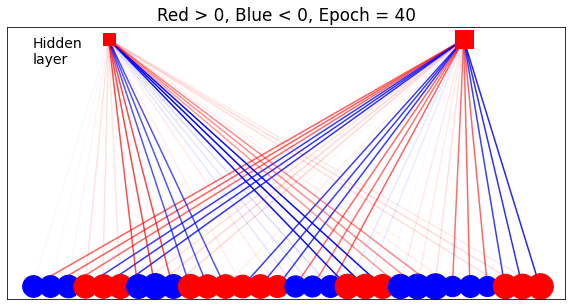

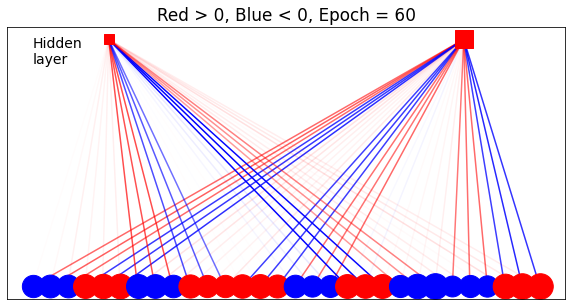

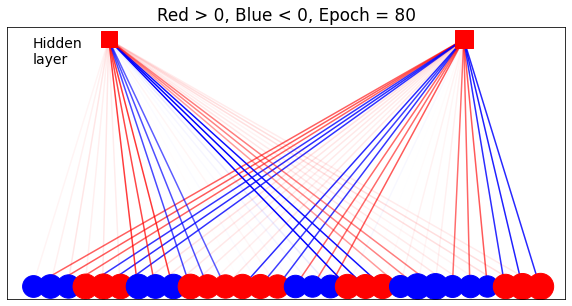

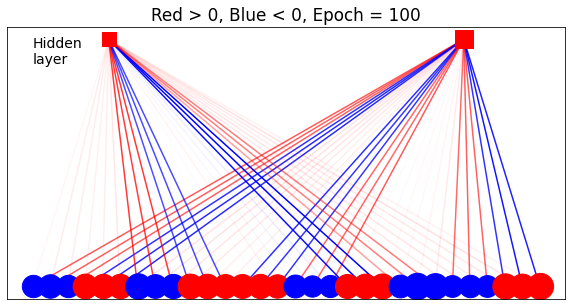

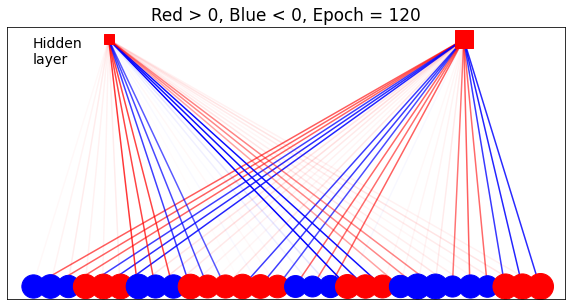

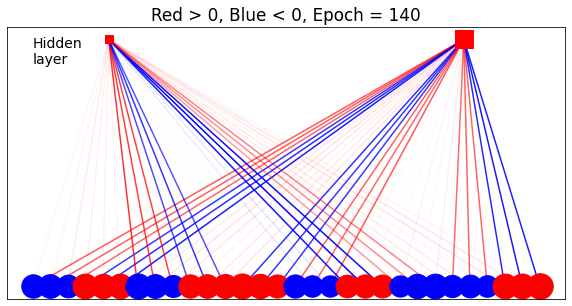

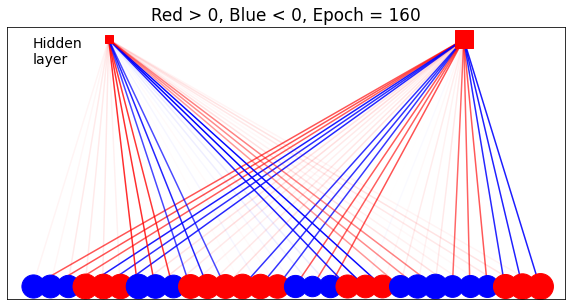

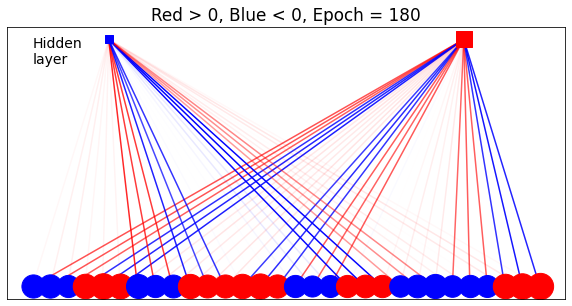

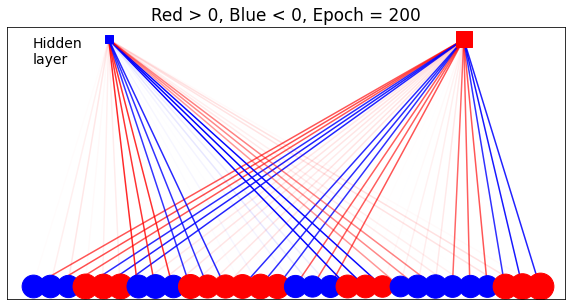

In [8]:
# learning rate
lrate = 0.02
# minibatch size and count
mb_size, mb_count = 500, 0

# model parameters
beta = 0.9
eps = 1e-8
sw, mw = 0, 0
sa, ma = 0, 0
sb, mb = 0, 0

# choose between 'rmsprop', 'adam', 'vanilla'
model = 'adam'
# number of divergent steps
div_steps = 2
# number of epochs
nepochs = 200

LogL = []
mean_energy = []
logZlist = []

AAIlist = []

# train model
for epoch in range(nepochs):
    E = []
    # loop over visible units
    for k in range(N):
           
        if mb_count == 0:
            # initialization step in the minibatch
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

        # positive CD phase: generate h
        h = activate(v[k], w, b, phase=1)
        # negative CD phase: generate fantasy vf
        vf = activate(h, w.T, a, phase=0)

        # additional divergent steps
        for i in range(div_steps - 1):
            hf = activate(vf, w, b, phase=1)
            vf = activate(hf, w.T, a, phase=0)

        # one more positive CD phase: fantasy hf from fantasy vf
        hf = activate(vf, w, b, phase=1)
    
        E.append(Energy(v[k], h, w, a, b))
        
        # update quantities
        v_data += v[k] / mb_size
        v_model += vf / mb_size 
        h_data += h / mb_size
        h_model += hf / mb_size
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)

        mb_count += 1
        if mb_count == mb_size: # reached the end of minibatch
            
            # complete average over minibatch
            vh_data /= mb_size
            vh_model /= mb_size
        
            # Vanilla GD
            if model == 'van':
                dw = lrate * (vh_data - vh_model)
                da = lrate * (v_data - v_model)
                db = lrate * (h_data - h_model)
            # RMSprop
            elif model == 'rmsprop':
                sw, dw = rmsprop(vh_data, vh_model, sw,
                                 beta, eps, lrate)
                sa, da = rmsprop(v_data, v_model, sa,
                                 beta, eps, lrate)
                sb, db = rmsprop(h_data, h_model, sb,
                                 beta, eps, lrate)
            # ADAM
            elif model == 'adam':
                mw, sw, dw = adam(vh_data, vh_model, mw, sw, epoch,
                                  beta, eps, lrate)
                ma, sa, da = adam(v_data, v_model, ma, sa, epoch,
                                  beta, eps, lrate)
                mb, sb, db = adam(h_data, h_model, mb, sb, epoch,
                                  beta, eps, lrate)
                                
            w = w + dw
            a = a + da
            b = b + db
            mb_count = 0 # move to the next minibatch
        
    # randomize the order of input data
    npr.shuffle(v)
    # decrease the learning rate if not using Adam
    if (model != 'adam'):
        lrate = lrate / (1 + 10 * lrate)

    if epoch % 20 == 19:
        plotgraph(epoch + 1)
        if (model != 'adam'):
            print(f'l_rate = {lrate}')

    logZ = np.log(PartZ(w, a, b))      
    mean_energy.append(np.mean(E))
    logZlist.append(logZ)
    LogL.append(-np.mean(E)-logZ)
    
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generate h
        h = activate(v0[k], w, b, phase=1)
        # negative CD phase: generating fantasy vf
        v1[k] = activate(h, w.T, a, phase=0)
    v1=((v1 - VMIN) / (1 - VMIN)).astype(int)
    AAIlist.append(AAI(v1,v0))


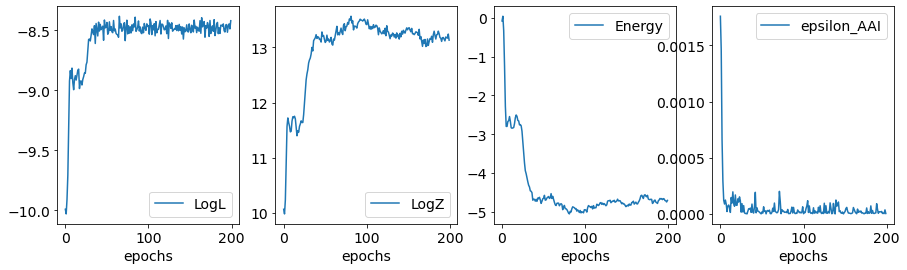

In [9]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
ax[0].plot(np.arange(nepochs), LogL, label='LogL')
ax[0].set_xlabel('epochs')
ax[1].plot(np.arange(nepochs), logZlist, label='LogZ' )
ax[1].set_xlabel('epochs')
ax[2].plot(np.arange(nepochs), mean_energy, label='Energy')
ax[2].set_xlabel('epochs')
ax[3].plot(np.arange(nepochs), [i[2] for i in AAIlist], label='epsilon_AAI')
ax[3].set_xlabel('epochs')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [10]:
# large GAP <-> low temperature
GAP *= 40

# original, non-reshuffled data is in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generate h
    h = activate(v0[k], w, b, phase=1)
    # negative CD phase: generating fantasy vf
    v1[k] = activate(h, w.T, a, phase=0)

# difference between model and data
diff = (v1 - v0) / 2
# save files with data
str0 = fname + '_M' + str(M) + '-mini' + str(mb_size)
np.savetxt(str0 + '.fantasy', (v1 + 1) / 2, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.diff', diff, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.w', w, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.a', a, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.b', b, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.logL', LogL, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.logZ', logZlist, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.energy', mean_energy, fmt='%d', delimiter=' ')

# cut full dataset to first nrows rows
nrows = 20
data = np.copy(v0[:nrows])
pred = np.copy(((v1[:nrows] - VMIN) / (1 - VMIN)).astype(int))

# convert one-hot encoding to polar/non-polar flags
one_per_block = range(0, v0.shape[1], BLSIZE)
for i in one_per_block:
    data[:, i] = np.argmax(data[:, i:(i + BLSIZE)], axis=1)
    pred[:, i] = np.argmax(pred[:, i:(i + BLSIZE)], axis=1)
data = pd.DataFrame(data[:, one_per_block])
pred = pd.DataFrame(pred[:, one_per_block])
thresh = BLSIZE // 2
data[data < thresh] = 0
data[data >= thresh] = 'P'
pred[pred < thresh] = 0
pred[pred >= thresh] = 'P'
data[data == 0] = 'N'
pred[pred == 0] = 'N'

# stylistic manipulations
data = data.style.set_table_attributes("style='display:inline'")
pred = pred.style.set_table_attributes("style='display:inline'")

def is_polar(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold; color: black'
    if cell_value == 'P':
        return color1
    return color0
data.applymap(is_polar)
pred.applymap(is_polar)

sty = [dict(selector='caption', props=[('font-size', '150%')])]
data.set_caption('Data').set_table_styles(sty)
pred.set_caption('Model').set_table_styles(sty)

display_html(data._repr_html_() + pred._repr_html_(), raw=True)

,0,1,2,3,4
0,P,N,N,P,P
1,N,N,N,P,P
2,N,P,P,N,N
3,N,N,P,N,N
4,P,N,N,P,N
5,N,P,P,N,N
6,N,P,P,P,N
7,P,N,N,N,P
8,N,N,P,P,N
9,P,P,N,N,P


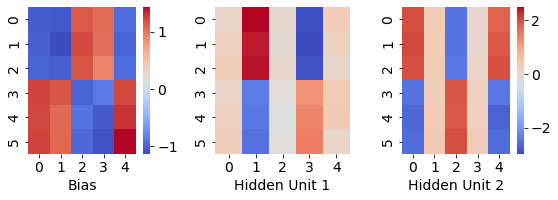

In [11]:
import seaborn as sns

wdf = np.copy(w)
bias = np.copy(a)
minb = min(bias)
maxb = max(bias)

fig, ax = plt.subplots(ncols=M+1, nrows=1, figsize=(8, 3))
minw=[]
maxw=[]

bias = bias.reshape(L//BLSIZE,BLSIZE)
bias = bias.T

sns.heatmap(bias, annot=False, cmap="coolwarm",
            # common colorbar displayed in the last plot
            ax=ax[0], vmin=minb, vmax=maxb)

ax[0].set_xlabel('Bias')

for i in range(M):
    wdfm = wdf[:,i].reshape(L//BLSIZE,BLSIZE)
    wdfm = wdfm.T
        
    minw.append(np.min(wdfm))
    maxw.append(np.max(wdfm))
    
    sns.heatmap(wdfm, annot=False, cmap="coolwarm",
               # common colorbar displayed in the last plot
               ax=ax[i+1], vmin=min(minw), vmax=max(maxw), cbar=i==M-1)
    ax[i+1].set_xlabel(f'Hidden Unit {i+1}')
    
# common labels
fig.tight_layout()    

In [12]:
v1=((v1 - VMIN) / (1 - VMIN)).astype(int)
AAI(v0,v1,10)

(0.8456, 0.5414, 0.12115332000000001)